In [1]:
from pathlib import Path
from asim.dataset.scene.arrow_scene import ArrowScene

<Axes: title={'center': 'Map: nuplan_us-ma-boston'}>

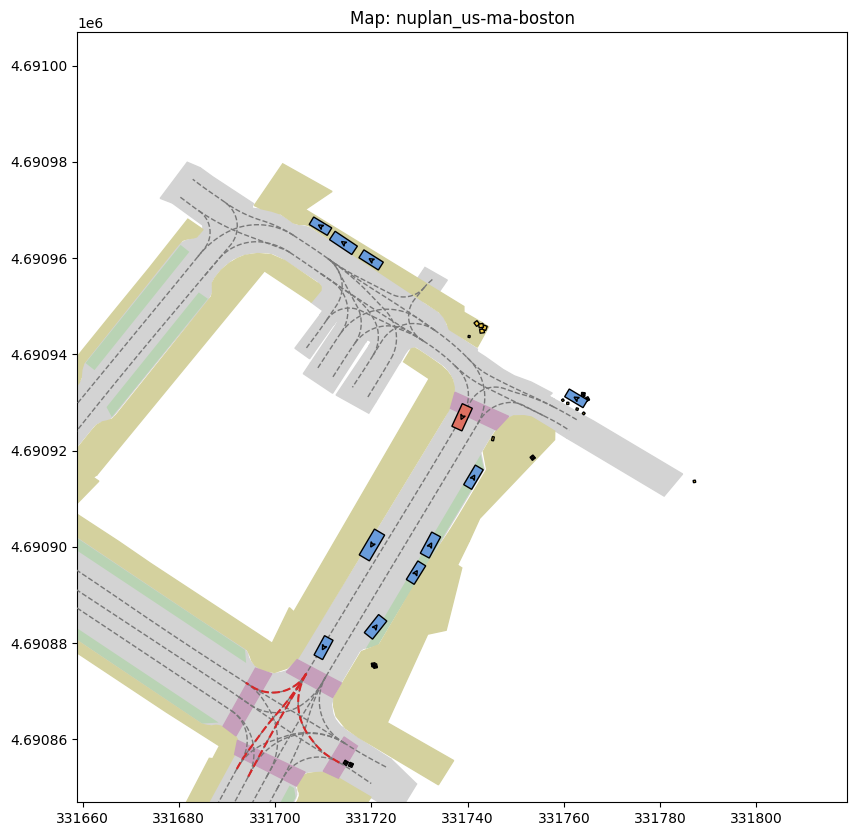

In [2]:
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt

import numpy as np

from asim.common.geometry.base import Point2D
from asim.common.geometry.bounding_box.bounding_box import BoundingBoxSE2, BoundingBoxSE3
from asim.common.geometry.tranform_2d import translate_along_yaw
from asim.common.visualization.color.color import ELLIS_5
from asim.dataset.scene.abstract_scene import AbstractScene

from asim.common.visualization.matplotlib.map import add_default_map_on_ax
from asim.common.visualization.matplotlib.observation import add_box_detections_to_ax, add_ego_vehicle_to_ax, add_traffic_lights_to_ax



def plot_scene_at_iteration(scene: AbstractScene, iteration: int = 0, ax: Optional[plt.Axes] = None):

    radius = 100

    ego_vehicle_state = scene.get_ego_vehicle_state_at_iteration(iteration)
    box_detections = scene.get_box_detections_at_iteration(iteration)
    traffic_light_detections = scene.get_traffic_light_detections_at_iteration(iteration)
    map_api = scene.map_api

    point_2d = ego_vehicle_state.bounding_box.center.state_se2.point_2d

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    add_default_map_on_ax(ax, map_api, point_2d, radius=radius)
    add_traffic_lights_to_ax(ax, traffic_light_detections, map_api)

    add_box_detections_to_ax(ax, box_detections)
    add_ego_vehicle_to_ax(ax, ego_vehicle_state)

    buffer_radius = 0.8 * radius
    ax.set_xlim(point_2d.x - buffer_radius, point_2d.x + buffer_radius)
    ax.set_ylim(point_2d.y - buffer_radius, point_2d.y + buffer_radius)

    ax.set_aspect("equal", adjustable="box")

    return ax


log_name = "2021.08.30.14.54.34_veh-40_00439_00835"
log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
scene = ArrowScene(log_file)

plot_scene_at_iteration(scene, iteration=3000)

In [3]:
# import io

# from PIL import Image
# from tqdm import tqdm


# def create_animation_gif(start_idx=0, end_idx=None, step=10, fps=20):
#     if end_idx is None:
#         end_idx = len(scene._recording_table)
#     # Calculate duration per frame in milliseconds
#     duration = int(1000 / fps)

#     # Create frames
#     images = []
#     for i in tqdm(range(start_idx, end_idx, step)):
#         fig, ax = plt.subplots(figsize=(10, 10))
#         plot_scene_at_iteration(scene, i, ax)

#         # Creating PIL image from fig
#         buf = io.BytesIO()
#         fig.savefig(buf, format="png")
#         buf.seek(0)
#         images.append(Image.open(buf).copy())

#         # Close buffer and figure
#         buf.close()
#         plt.close(fig)

#     # Save the GIF with the specified FPS
#     images[0].save(f"{log_name}.gif", save_all=True, append_images=images[1:], duration=duration, loop=0)

# log_name = "2021.06.07.12.54.00_veh-35_01843_02314"
# log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
# scene = ArrowScene(log_file)

# # Create a gif animation with a specific FPS
# # create_animation_gif(fps=30, end_idx=None, step=5)

In [4]:

import traceback
import matplotlib.animation as animation

def create_animation_mp4(scene: AbstractScene, output_path: Path, start_idx=0, end_idx=None, step=10, fps=20):
    if end_idx is None:
        end_idx = len(scene._recording_table)

    fig, ax = plt.subplots(figsize=(10, 10))

    def update(i):
        ax.clear()
        plot_scene_at_iteration(scene, i, ax)
        # Adjust border size (white space) around the figure
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    frames = list(range(start_idx, end_idx, step))
    ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False, cache_frame_data=False, blit=False)

    ani.save(output_path / f"{log_name}.mp4", writer='ffmpeg', fps=fps, dpi=300)
    plt.close(fig)

# # Create an mp4 animation with a specific FPS
output_path = Path("/home/daniel/asim_logs_videos")
# log_path = Path("/home/daniel/asim_workspace/data/carla")
# for log_file in log_path.iterdir():
#     print(f"Processing {log_file.stem}...")
#     log_name = log_file.stem
#     scene = ArrowScene(log_file)
#     try:
#         create_animation_mp4(scene, output_path, fps=30, end_idx=None, step=5)
#     except Exception as e:
#         traceback.print_exc()
#         erroneous_file = output_path / f"{log_name}.mp4"
#         if erroneous_file.exists():
#             erroneous_file.unlink()
#     del scene


log_file = Path("/home/daniel/asim_workspace/data/mini") / "2021.08.30.14.54.34_veh-40_00439_00835.arrow"
scene = ArrowScene(log_file)
create_animation_mp4(scene, output_path, fps=30, end_idx=None, step=5)

